In [1]:

from langchain_google_vertexai import ChatVertexAI
from typing import TypedDict, Annotated
from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages
from utils import get_retrieval_from_vstore, check_stock, notify_technicien, get_retriever_tool, get_db
# from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
# from langgraph.prebuilt import tools_condition
from langchain_core.messages import SystemMessage, HumanMessage
from IPython.display import Image, display

In [2]:
plan_prompt = "Below is the current task we will work on and the relevant information related to it. Please develop a plan of action to address this task. "

system_promp = """
You are an AI assistant at machines' maintenance and reparation.
you will receive notification code send from the machines, investigate the code and do everything needed to handle it.
give detailed instruction of what need to be done.
execute the task in sequence not in parallel.
"""

In [3]:
retriever = get_retrieval_from_vstore()
agent_tools = [check_stock, notify_technicien, get_retriever_tool(retriever)]
model = ChatVertexAI(model="gemini-1.5-flash-002", temperature=0)
llm_with_tools = model.bind_tools(agent_tools)
memory = get_db()

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
def generate(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messges":response} 

def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [6]:
def build_agent():
    # memory = MemorySaver()
    builder = StateGraph(State)

    tool_node = ToolNode(agent_tools)

    builder.add_node("generate", generate)
    builder.add_node("tools", tool_node)

    builder.add_edge(START, "generate")
    builder.add_edge("tools", "generate")

    builder.add_conditional_edges(
    "generate",
    route_tools,
    {"tools":"tools",END:END}
    )

    return builder.compile(checkpointer=memory)

graph = build_agent()
thread = {"configurable":{"thread_id":"1"}}

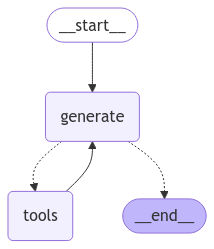

In [7]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
messages = [
    SystemMessage(content=system_promp),
    HumanMessage(content="error message : E18XP")
]
thread = {"configurable":{"thread_id":"1"}}

output = graph.invoke({"messages":messages}, thread)
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

error message : E18XP


In [10]:
output = graph.invoke(None, thread)
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

error message : E18XP
